In [1]:
import datetime
from itertools import combinations
from typing import NamedTuple
from matplotlib import pyplot as plot
from git import Repo
import networkx as nx


In [2]:
repo = Repo("../quizzology")

In [3]:
repo_graph = nx.Graph()
for commit in repo.iter_commits():
    for (left,right) in combinations(commit.stats.files,2):
        repo_graph.add_edge(left,right)

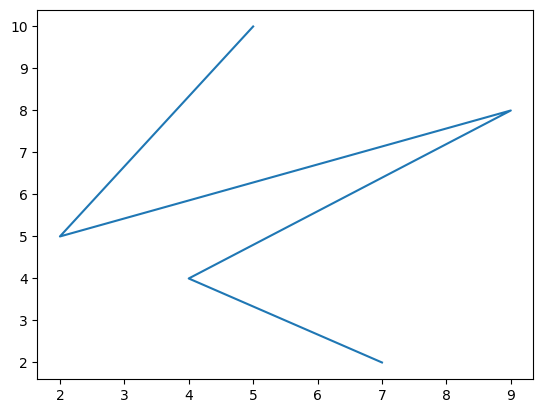

In [4]:
# Create a plot 

x = [5, 2, 9, 4, 7]
y = [10, 5, 8, 4, 2]
plot.plot(x, y)
plot.show()

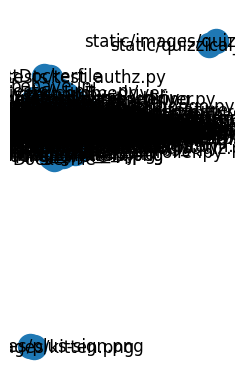

In [5]:
# Draw a network plot of some kind

# graph = nx.petersen_graph() # well known sample data 
# subax = plot.subplot(121)
# nx.draw(graph)

repo_plot = plot.subplot(122)
nx.draw(repo_graph, with_labels=True)

